# Natural Language Processing - Text Summarization example

### 0 - Setup

###### Import pckgs

In [1]:
import warnings
warnings.filterwarnings("ignore")
# from nlp_utils import *

###### Import data

In [2]:
from utils import *
from transformers import Seq2SeqTrainer
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer

from transformers import Seq2SeqTrainingArguments


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
import pandas as pd
import datasets
import nltk
import re
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
import rouge
import numpy as np
import difflib
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize
import evaluate

rouge_score = evaluate.load("rouge")
#dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')

#lst_dics = [dic for dic in dataset["train"]]
#dtf = pd.DataFrame(lst_dics).rename(columns={"article":"text", "highlights":"y"})[["text","y"]].head(20000)
#dtf.to_csv("data_summary.csv", index=False)
#dtf.head()

In [4]:
data = datasets.load_dataset("xsum")

Found cached dataset xsum (/Users/vazgen/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
data

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [6]:
lst_dics = [dic for dic in data["train"]]
dtf = pd.DataFrame(lst_dics).rename(columns={"document":"text", "summary":"y"})[["text","y"]].head(20000)

In [7]:
dtf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   y       20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [8]:
# check
i = 1
print("--- Full text ---")
print(dtf["text"][i])
print(" ")
print("--- Summary ---")
print(dtf["y"][i])

--- Full text ---
A fire alarm went off at the Holiday Inn in Hope Street at about 04:20 BST on Saturday and guests were asked to leave the hotel.
As they gathered outside they saw the two buses, parked side-by-side in the car park, engulfed by flames.
One of the tour groups is from Germany, the other from China and Taiwan. It was their first night in Northern Ireland.
The driver of one of the buses said many of the passengers had left personal belongings on board and these had been destroyed.
Both groups have organised replacement coaches and will begin their tour of the north coast later than they had planned.
Police have appealed for information about the attack.
Insp David Gibson said: "It appears as though the fire started under one of the buses before spreading to the second.
"While the exact cause is still under investigation, it is thought that the fire was started deliberately."
 
--- Summary ---
Two tourist buses have been destroyed by fire in a suspected arson attack in Belf

### 1 - Text Analysis

- Text cleaning
- Word frequency
- Length analysis

###### Text cleaning

In [9]:
lst_stopwords = create_stopwords()
lst_stopwords = lst_stopwords + ["cnn","say","said","new","wa","ha"]

In [10]:
dtf = add_preprocessed_text(dtf, column="text", 
                            punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, lemm=True)
dtf = add_preprocessed_text(dtf, column="y", 
                            punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, lemm=True)
dtf.head()

--- found NAs ---
      text text_clean
7685                 
8241                 
18941                
--- found NAs ---
       y y_clean
964    .        
14712  .        
14920  .        


,text,y,text_clean,y_clean
0,"The full cost of damage in Newton Stewart, one...",Clean-up operations are continuing across the ...,full cost damage newton stewart one area worst...,cleanup operation continuing across scottish b...
1,A fire alarm went off at the Holiday Inn in Ho...,Two tourist buses have been destroyed by fire ...,fire alarm went holiday inn hope street 0420 b...,two tourist bus destroyed fire suspected arson...
2,Ferrari appeared in a position to challenge un...,Lewis Hamilton stormed to pole position at the...,ferrari appeared position challenge final lap ...,lewis hamilton stormed pole position bahrain g...
3,"John Edward Bates, formerly of Spalding, Linco...",A former Lincolnshire Police officer carried o...,john edward bates formerly spalding lincolnshi...,former lincolnshire police officer carried ser...
4,Patients and staff were evacuated from Cerahpa...,An armed man who locked himself into a room at...,patient staff evacuated cerahpasa hospital wed...,armed man locked room psychiatric hospital ist...


In [11]:
# check
print("--- Full text ---")
print(dtf["text_clean"][i])
print(" ")
print("--- Summary ---")
print(dtf["y_clean"][i])

--- Full text ---
fire alarm went holiday inn hope street 0420 bst saturday guest asked leave hotel gathered outside saw two bus parked sidebyside car park engulfed flame one tour group germany china taiwan first night northern ireland driver one bus many passenger left personal belonging board destroyed group organised replacement coach begin tour north coast later planned police appealed information attack insp david gibson appears though fire started one bus spreading second exact still investigation thought fire started deliberately
 
--- Summary ---
two tourist bus destroyed fire suspected arson attack belfast city centre


###### Word frequency

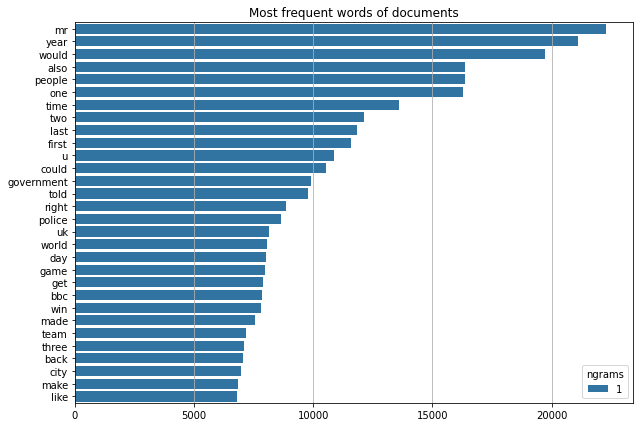

In [12]:
# Find most common words in text
dtf_freq = word_freq(corpus=dtf["text_clean"], ngrams=[1], top=30, figsize=(10,7),title="Most frequent words of documents")

In [13]:
thres = 5
X_top_words = len(dtf_freq[dtf_freq["freq"]>thres])
X_top_words

32249

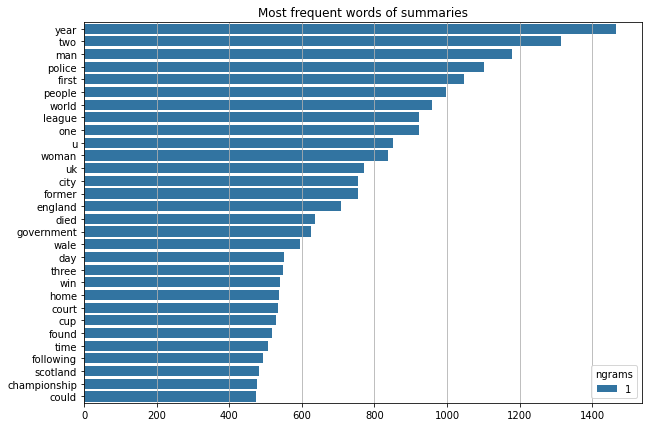

In [14]:
# Find most common words in summaries
dtf_freq = word_freq(corpus=dtf["y_clean"], ngrams=[1], top=30, figsize=(10,7),title="Most frequent words of summaries")

In [15]:
thres = 5
y_top_words = len(dtf_freq[dtf_freq["freq"]>thres])
y_top_words

5905

###### Length analysis

In [16]:
# Texts
X = add_text_length(dtf, "text_clean")

                         min         mean           max
char_count           15.0000  1268.920726  19090.000000
word_count            2.0000   208.703261   2967.000000
sentence_count        1.0000     1.000000      1.000000
avg_word_length       4.1875     6.068730      7.913043
avg_sentence_lenght   2.0000   208.703261   2967.000000


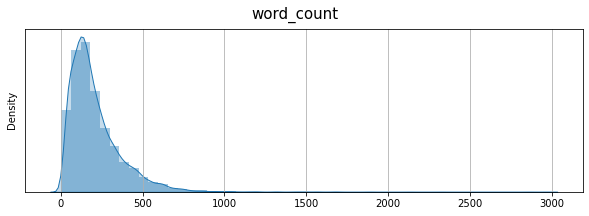

In [17]:
plot_distributions(X, x="word_count", figsize=(10,3))

In [18]:
X_len = 400

In [19]:
# Summaries
y = add_text_length(dtf, "y_clean")

                      min       mean     max
char_count           4.00  78.380064  225.00
word_count           1.00  12.729269   36.00
sentence_count       1.00   1.000000    1.00
avg_word_length      3.25   6.188574   10.75
avg_sentence_lenght  1.00  12.729269   36.00


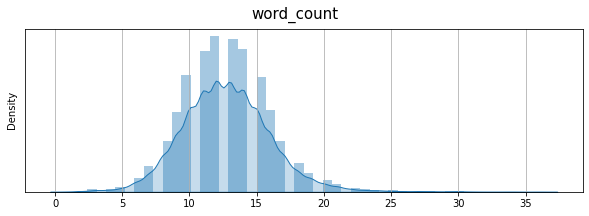

In [20]:
plot_distributions(y, x="word_count", max_cat=1, figsize=(10,3))

In [21]:
y_len = 40

###### Summary

In [22]:
dtf = dtf[["text","text_clean","y","y_clean"]]
dtf.head()

,text,text_clean,y,y_clean
0,"The full cost of damage in Newton Stewart, one...",full cost damage newton stewart one area worst...,Clean-up operations are continuing across the ...,cleanup operation continuing across scottish b...
1,A fire alarm went off at the Holiday Inn in Ho...,fire alarm went holiday inn hope street 0420 b...,Two tourist buses have been destroyed by fire ...,two tourist bus destroyed fire suspected arson...
2,Ferrari appeared in a position to challenge un...,ferrari appeared position challenge final lap ...,Lewis Hamilton stormed to pole position at the...,lewis hamilton stormed pole position bahrain g...
3,"John Edward Bates, formerly of Spalding, Linco...",john edward bates formerly spalding lincolnshi...,A former Lincolnshire Police officer carried o...,former lincolnshire police officer carried ser...
4,Patients and staff were evacuated from Cerahpa...,patient staff evacuated cerahpasa hospital wed...,An armed man who locked himself into a room at...,armed man locked room psychiatric hospital ist...


### 2 - Preprocessing

In [23]:
# Partitioning
dtf_train = dtf.iloc[i+1:]
dtf_test = dtf.iloc[:i+1]
dtf_test

,text,text_clean,y,y_clean
0,"The full cost of damage in Newton Stewart, one...",full cost damage newton stewart one area worst...,Clean-up operations are continuing across the ...,cleanup operation continuing across scottish b...
1,A fire alarm went off at the Holiday Inn in Ho...,fire alarm went holiday inn hope street 0420 b...,Two tourist buses have been destroyed by fire ...,two tourist bus destroyed fire suspected arson...


### 3 - Baseline (Extractive: TextRank)

In [24]:
# !pip install bert-extractive-summarizer

In [25]:
# Test (no Train)
predicted = tex_trank(corpus=dtf_test["text"],num_sentences=5)
# predicted = tex_trank(corpus=dtf_test["text"], ratio=y_len/X_len)

In [26]:
# !pip install rouge

In [27]:
# Evaluate
evaluate_summary(dtf_test["y"][i], predicted[i])

rouge1: 0.13 | rouge2: 0.0 | rougeL: 0.0 --> avg rouge: 0.09


In [28]:
# Compare y_test and predicted
match = display_string_matching(dtf_test["y"][i], predicted[i], both=True, sentences=False, 
                                titles=["Real Summary", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))

In [29]:
# Explainability
match = display_string_matching(dtf_test["text"][i], predicted[i], both=True, sentences=True, 
                                titles=["Full Text", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))

### 4 - Model Abstractive

In [30]:
import torch
import transformers
from datasets import load_dataset, load_metric, load_from_disk
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/vazgen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
#data
metric = load_metric('rouge')
model_checkpoints = 'facebook/bart-base'

Defining model varaibles

In [32]:

max_input = 512
max_target = 128
tokenizer = transformers.AutoTokenizer.from_pretrained(model_checkpoints)
device = torch.device('mps')

# tokenizer.to(device)

In [33]:
#DEFINING FUCTION FOR PROCESSING DATA

def preprocess_data(data_to_process):
    #get the dialogue text
    inputs = [dialogue for dialogue in data_to_process['document']]
    #tokenize text
    model_inputs = tokenizer(inputs,  max_length=max_input, padding='max_length', truncation=True)
  
    #tokenize labels
    with tokenizer.as_target_tokenizer():
        targets = tokenizer(data_to_process['summary'], max_length=max_target, padding='max_length', truncation=True)
      
    model_inputs['labels'] = targets['input_ids']
    #reuturns input_ids, attention_masks, labels
    return model_inputs
#tokenizing data
tokenize_data = data.map(preprocess_data, batched = True, remove_columns=['id', 'document', 'summary'])

Loading cached processed dataset at /Users/vazgen/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71/cache-90cd952caef5e345.arrow


  0%|          | 0/12 [00:00<?, ?ba/s]

Loading cached processed dataset at /Users/vazgen/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71/cache-473a87a18ec44363.arrow


In [34]:
data

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [35]:
tokenize_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 11334
    })
})

In [36]:
#splitting data for illustrative purpose

#sample the data
train_sample = tokenize_data['train'].shuffle(seed=123).select(range(1000))
validation_sample = tokenize_data['validation'].shuffle(seed=123).select(range(200))
test_sample = tokenize_data['test'].shuffle(seed=123).select(range(200))

tokenize_data['train'] = train_sample
tokenize_data['validation'] = validation_sample
tokenize_data['test'] = test_sample
     


Loading cached shuffled indices for dataset at /Users/vazgen/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71/cache-4adfb9d376b9485d.arrow
Loading cached shuffled indices for dataset at /Users/vazgen/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71/cache-3a86f5ebd9cb06d6.arrow


# Initializing Model with pretrained weights

In [37]:

model = transformers.AutoModelForSeq2SeqLM.from_pretrained(model_checkpoints)

model.to(device)
#collator to create batches. It preprocess data with the given tokenizer
collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)

In [38]:

#####################
# metrics
# compute rouge for evaluation 
#####################

def compute_rouge(pred):
    predictions, labels = pred
    #decode the predictions
    decode_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    #decode labels
    decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
  
    #compute results
    res = metric.compute(predictions=decode_predictions, references=decode_labels, use_stemmer=True)
    #get %
    res = {key: value.mid.fmeasure * 100 for key, value in res.items()}
  
    pred_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    res['gen_len'] = np.mean(pred_lens)
  
    return {k: round(v, 4) for k, v in res.items()}

In [39]:

args = transformers.Seq2SeqTrainingArguments(
    'bart_trained_xsum',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size= 1,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    eval_accumulation_steps=1,
#     fp16=True
    )

trainer = transformers.Seq2SeqTrainer(
    model, 
    args,
    train_dataset=tokenize_data['train'],
    eval_dataset=tokenize_data['validation'],
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge
)

# Fitting a model

In [40]:
trainer.train()

***** Running training *****
  Num examples = 1000
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 2
  Total optimization steps = 1500


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,1.721400,0.458949,33.337800,11.761600,26.467900,26.410800,19.370000
2,0.466500,0.450347,33.675200,12.511400,27.170300,27.160600,19.715000
3,0.400800,0.453694,34.173200,12.750700,27.659500,27.656700,19.745000


Saving model checkpoint to bart_trained_xsum/checkpoint-500
Configuration saved in bart_trained_xsum/checkpoint-500/config.json
Model weights saved in bart_trained_xsum/checkpoint-500/pytorch_model.bin
tokenizer config file saved in bart_trained_xsum/checkpoint-500/tokenizer_config.json
Special tokens file saved in bart_trained_xsum/checkpoint-500/special_tokens_map.json
Deleting older checkpoint [bart_trained_xsum/checkpoint-1000] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 200
  Batch size = 1
Saving model checkpoint to bart_trained_xsum/checkpoint-1000
Configuration saved in bart_trained_xsum/checkpoint-1000/config.json
Model weights saved in bart_trained_xsum/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in bart_trained_xsum/checkpoint-1000/tokenizer_config.json
Special tokens file saved in bart_trained_xsum/checkpoint-1000/special_tokens_map.json
Deleting older checkpoint [bart_trained_xsum/checkpoint-1500] due to args.save_total_li

TrainOutput(global_step=1500, training_loss=0.8629236348470052, metrics={'train_runtime': 3414.4853, 'train_samples_per_second': 0.879, 'train_steps_per_second': 0.439, 'total_flos': 914604687360000.0, 'train_loss': 0.8629236348470052, 'epoch': 3.0})

In [41]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 200
  Batch size = 1


{'eval_loss': 0.4536937475204468,
 'eval_rouge1': 34.1732,
 'eval_rouge2': 12.7507,
 'eval_rougeL': 27.6595,
 'eval_rougeLsum': 27.6567,
 'eval_gen_len': 19.745,
 'eval_runtime': 275.6191,
 'eval_samples_per_second': 0.726,
 'eval_steps_per_second': 0.726,
 'epoch': 3.0}

In [42]:
text = dtf_test["text"][i]

In [43]:
#tokenize the conversation
model_inputs = tokenizer(text,  max_length=max_input, padding='max_length', truncation=True)
#make prediction
raw_pred, _, _ = trainer.predict([model_inputs])

result = tokenizer.decode(raw_pred[0]).replace("</s>","").replace("<pad>","").replace("<s>","")
#decode the output


print(result)

***** Running Prediction *****
  Num examples = 1
  Batch size = 1


Two tour groups have been attacked by two buses in Belfast.


In [44]:
# Explainability
match = display_string_matching(dtf_test["text"][i], result, both=True, sentences=False, 
                                titles=["Full Text", "Predicted Summary"])

from IPython.core.display import display, HTML
display(HTML(match))
print(f'Actual summary:{dtf_test["y"][i]}')

Actual summary:Two tourist buses have been destroyed by fire in a suspected arson attack in Belfast city centre.


In [45]:
evaluate_summary(dtf_test["y"][i], predicted[i])

rouge1: 0.13 | rouge2: 0.0 | rougeL: 0.0 --> avg rouge: 0.09


In [46]:
evaluate_summary(dtf_test["y"][i], result)

rouge1: 0.52 | rouge2: 0.15 | rougeL: 0.15 --> avg rouge: 0.37


# Load

In [49]:
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["document"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["summary"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [50]:
tokenized_datasets = data.map(preprocess_function, batched=True)

  0%|          | 0/12 [00:00<?, ?ba/s]

In [73]:
model_name = 'Paligonshik/pegasus-large-finetune-xsum'
from transformers import Seq2SeqTrainingArguments

max_input_length = 512
max_target_length = 30
batch_size = 8
num_train_epochs = 3
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["train"]) // batch_size
# model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}",
    evaluation_strategy="epoch",
    learning_rate=5.6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    generation_max_length=max_input,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [74]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [75]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [76]:
data

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [77]:
model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["document"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["summary"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
tokenized_datasets = data.map(preprocess_function, batched=True)

loading configuration file https://huggingface.co/google/mt5-small/resolve/main/config.json from cache at /Users/vazgen/.cache/huggingface/transformers/97693496c1a0cae463bd18428187f9e9924d2dfbadaa46e4d468634a0fc95a41.dadce13f8f85f4825168354a04675d4b177749f8f11b167e87676777695d4fe4
Model config MT5Config {
  "_name_or_path": "google/mt5-small",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "d_ff": 1024,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "mt5",
  "num_decoder_layers": 8,
  "num_heads": 6,
  "num_layers": 8,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "transformers_version": "4.18.0",
  "use_cache": true,
  "vocab_size": 250112
}

loa

  0%|          | 0/12 [00:00<?, ?ba/s]

In [78]:
model2 = AutoModelForSeq2SeqLM.from_pretrained('Paligonshik/mt5-small-finetune-sumsum')
trainer2 = Seq2SeqTrainer(
    model2,
    args,
    train_dataset=tokenize_data["train"],
    eval_dataset=tokenize_data["validation"],
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge,
)

loading configuration file https://huggingface.co/Paligonshik/mt5-small-finetune-sumsum/resolve/main/config.json from cache at /Users/vazgen/.cache/huggingface/transformers/9633a5c3ab445d813c376ecfdaa6d0d708b24e7cf9efc04acda49bc1d409dcc4.befe39e9588513959b94c3916f8f56144e1d9cf5ec098657fc5af1fde9d5439c
Model config MT5Config {
  "_name_or_path": "Paligonshik/mt5-small-finetune-sumsum",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "d_ff": 1024,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "mt5",
  "num_decoder_layers": 8,
  "num_heads": 6,
  "num_layers": 8,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "tokenizer_class": "T5Tokenizer",
  "torch_dtype": "float32",
  "transformers_

In [79]:
test_sample = preprocess_function(data['test'][10])

In [82]:
pred = trainer2.predict([test_sample])

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


In [93]:
pred = trainer2.predict([test_sample])
result = tokenizer.decode(pred[1][0]).replace("</s>","").replace("<pad>","")
result

***** Running Prediction *****
  Num examples = 1
  Batch size = 8


"Queen's University Belfast is cutting 236 jobs and 290 student places due to a funding reduction."

In [95]:
trainer2.evaluate()

***** Running Evaluation *****
  Num examples = 200
  Batch size = 8


{'eval_loss': 8.904062271118164,
 'eval_rouge1': 0.119,
 'eval_rouge2': 0.0,
 'eval_rougeL': 0.0823,
 'eval_rougeLsum': 0.0853,
 'eval_gen_len': 428.08,
 'eval_runtime': 711.9969,
 'eval_samples_per_second': 0.281,
 'eval_steps_per_second': 0.035}